# LSTM Bot

## Project Overview

In this project, you will build a chatbot that can converse with you at the command line. The chatbot will use a Sequence to Sequence text generation architecture with an LSTM as it's memory unit. You will also learn to use pretrained word embeddings to improve the performance of the model. At the conclusion of the project, you will be able to show your chatbot to potential employers.

Additionally, you have the option to use pretrained word embeddings in your model. We have loaded Brown Embeddings from Gensim in the starter code below. You can compare the performance of your model with pre-trained embeddings against a model without the embeddings.



---



A sequence to sequence model (Seq2Seq) has two components:
- An Encoder consisting of an embedding layer and LSTM unit.
- A Decoder consisting of an embedding layer, LSTM unit, and linear output unit.

The Seq2Seq model works by accepting an input into the Encoder, passing the hidden state from the Encoder to the Decoder, which the Decoder uses to output a series of token predictions.

## Dependencies

- Pytorch
- Numpy
- Pandas
- NLTK
- Gzip
- Gensim


Please choose a dataset from the Torchtext website. We recommend looking at the Squad dataset first. Here is a link to the website where you can view your options:

- https://pytorch.org/text/stable/datasets.html





In [1]:
!pip install nltk

In [2]:
import nltk
import pandas as pd
import string
import torch
import neptune
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

In [3]:
stemmer = nltk.stem.snowball.SnowballStemmer('english')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def getDict(dataPipe):

    data_dict = {
        'Question': [],
        'Answer': []
    }
    
    for _, question, answers, _ in dataPipe:
        data_dict['Question'].append(question)
        data_dict['Answer'].append(answers[0])
        
    return data_dict


def loadDF(path):
    # load data
    train_data, val_data = torchtext.datasets.SQuAD2|(path)
    
    # convert dataPipe to dictionary 
    train_dict, val_dict = getDict(train_data), getDict(val_data)
    
    # convert Dictionaries to Pandas DataFrame
    train_df = pd.DataFrame(train_dict)    
    validation_df = pd.DataFrame(val_dict)    
    
    return train_df.append(validation_df)


def prepare_text(sentence):
    # clean text and tokenize it 
    sentence = ''.join([s.lower() for s in sentence if s not in string.punctuation])
    sentence = ' '.join(stemmer.stem(w) for w in sentence.split())
    tokens = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(sentence)

    return tokens


def toTensor(vocab, sentence):
    # convert list of words "sentence" to a torch tensor of indices
    indices = [vocab.word2index[word] for word in sentence.split(' ')]
    indices.append(vocab.word2index[''])
    return torch.Tensor(indices).long().to(device).view(-1, 1)


def getPairs(df):
    # convert df to list of pairs
    temp1 = df['Question'].apply(lambda x: " ".join(x) ).to_list()
    temp2 = df['Answer'].apply(lambda x: " ".join(x) ).to_list()
    return [list(i) for i in zip(temp1, temp2)]


def getMaxLen(pairs):
    max_src = 0 
    max_trg = 0
    
    for p in pairs:
        max_src = len(p[0].split()) if len(p[0].split()) > max_src else max_src
        max_trg = len(p[1].split()) if len(p[1].split()) > max_trg else max_trg
        
    return max_src, max_trg



## Arsitektur

In [15]:
import random 
import torch
import torch.nn as nn


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(self.input_size, self.hidden_size)
        self.input = nn.Linear(self.input_size, self.hidden_size)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)

    def forward(self, x, hidden, cell_state):
        x = self.embedding(x)
        x = x.view(1, 1, -1)
        x, (hidden, cell_state) = self.lstm(x, (hidden, cell_state))
        return x, hidden, cell_state
        

class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.embedding = nn.Embedding(output_size, self.hidden_size)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim= 1)

    def forward(self, x, hidden, cell_state):
        x = self.embedding(x)
        x = x.view(1, 1, -1)
        x, (hidden, cell_state) = self.lstm(x, (hidden, cell_state))
        x = self.softmax(self.fc(x[0]))
        return x, hidden, cell_state
    
    
class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Seq2Seq, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.encoder = Encoder(self.input_size, self.hidden_size)
        self.decoder = Decoder(self.hidden_size, self.output_size)
        
    def forward(self, src, trg, src_len, trg_len, teacher_force=1):
        
        output = {
            'decoder_output':[]
        }
        
        encoder_hidden = torch.zeros([1, 1, self.hidden_size]).to(device) # 1 = number of LSTM layers
        cell_state = torch.zeros([1, 1, self.hidden_size]).to(device)  
        
        for i in range(src_len):
            encoder_output, encoder_hidden, cell_state = self.encoder(src[i], encoder_hidden, cell_state)

        decoder_input = torch.Tensor([[0]]).long().to(device) # 0 = SOS_token
        decoder_hidden = encoder_hidden
        
        for i in range(trg_len):
            decoder_output, decoder_hidden, cell_state = self.decoder(decoder_input, decoder_hidden, cell_state)
            output['decoder_output'].append(decoder_output)
            
            if self.training: # Model not in eval mode
                decoder_input = target_tensor[i] if random.random() > teacher_force else decoder_output.argmax(1) # teacher forcing
            else:
                _, top_index = decoder_output.data.topk(1)
                decoder_input = top_index.squeeze().detach()
                
        return output


In [4]:
project = "andialifs/siet-24"
api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjZTY2YWQ3My04OTBkLTQ2OWUtYTc1Ni1jYjk0MGZhMWFiNGEifQ=="

def neptune_init(name):
    run = neptune.init_run(
        project=project,
        api_token=api_token,
        name=name
    )
    return run

## Train Function

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
def calculate_bleu(preds, questions, answers):
    bleu_score_1 = 0
    bleu_score_2 = 0
    bleu_score_3 = 0
    bleu_score_4 = 0
    cum_bleu_score_1 = 0
    cum_bleu_score_2 = 0
    cum_bleu_score_3 = 0
    cum_bleu_score_4 = 0

    num_of_rows_calculated = 0
    smoothing_function = SmoothingFunction().method1

    for i, (question, real_answer) in enumerate(zip(questions, answers)):
        # print(f"Question: {question}")
        # print(f"Real Answer: {real_answer}")
        # print(f"Predicted Answer: {preds[i]}")
        refs = [real_answer.split(' ')]
        hyp = preds[i].split(' ')

        bleu_score_1 += sentence_bleu(refs, hyp, weights=(1,0,0,0), smoothing_function=smoothing_function)
        bleu_score_2 += sentence_bleu(refs, hyp, weights=(0,1,0,0), smoothing_function=smoothing_function)
        bleu_score_3 += sentence_bleu(refs, hyp, weights=(0,0,1,0), smoothing_function=smoothing_function)
        bleu_score_4 += sentence_bleu(refs, hyp, weights=(0,0,0,1), smoothing_function=smoothing_function)
        cum_bleu_score_1 += sentence_bleu(refs, hyp, weights=(1,0,0,0), smoothing_function=smoothing_function)
        cum_bleu_score_2 += sentence_bleu(refs, hyp, weights=(0.5,0.5,0,0), smoothing_function=smoothing_function)
        cum_bleu_score_3 += sentence_bleu(refs, hyp, weights=(0.33,0.33,0.33,0), smoothing_function=smoothing_function)
        cum_bleu_score_4 += sentence_bleu(refs, hyp, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothing_function)

        num_of_rows_calculated+=1

    results = {"1-gram": (bleu_score_1/num_of_rows_calculated),
                "2-gram": (bleu_score_2/num_of_rows_calculated),
                "3-gram": (bleu_score_3/num_of_rows_calculated),
                "4-gram": (bleu_score_4/num_of_rows_calculated),
                "cumulative-1-gram": (cum_bleu_score_1/num_of_rows_calculated),
                "cumulative-2-gram": (cum_bleu_score_2/num_of_rows_calculated),
                "cumulative-3-gram": (cum_bleu_score_3/num_of_rows_calculated),
                "cumulative-4-gram": (cum_bleu_score_4/num_of_rows_calculated)}

    return results

In [7]:
SOS_token = 0
EOS_token = 1

class Vocab:
    def __init__(self):
        self.word2index = {"": SOS_token, "": EOS_token}
        self.index2word = {SOS_token: "", EOS_token: ""}
        self.words_count = len(self.word2index)

    def add_words(self, sentence):
        for word in sentence.split(" "):
            if word not in self.word2index:
                self.word2index[word] = self.words_count
                self.index2word[self.words_count] = word
                self.words_count += 1


In [8]:
learning_rate = 0.0001
hidden_size = 512 # encoder and decoder hidden size
batch_size = 1
epochs = 150

In [9]:
# knowledgebase = pd.read_excel('https://raw.githubusercontent.com/AndiAlifs/FLUENT-Chatbot-2023/main/KnowledgeBaseFilkom.xlsx', engine='openpyxl')
knowledgebase = pd.read_excel('https://raw.githubusercontent.com/AndiAlifs/FLUENT-Chatbot-2023/main/KnowledgeBaseFilkom_simple.xlsx', engine='openpyxl')
knowledgebase.head()

qa_paired = knowledgebase.drop(columns=knowledgebase.columns.drop(['Pertanyaan', 'Jawaban']))
qa_paired.dropna(inplace=True)

In [10]:
knowledgebase = pd.read_excel('https://raw.githubusercontent.com/AndiAlifs/FLUENT-Chatbot-2023/main/KnowledgeBaseFilkom_eval.xlsx', engine='openpyxl')
knowledgebase.head()

qa_paired_eval = knowledgebase.drop(columns=knowledgebase.columns.drop(['Pertanyaan', 'Jawaban']))
qa_paired_eval.dropna(inplace=True)


In [11]:
# data_df = loadDF('data')
# I will take only the first 5,000 Q&A to avoid CUDA out of memory error due to the large dataset
# data_df = data_df.iloc[:5000, :]
data_df = pd.DataFrame(columns=['Question', 'Answer'])
data_df['Question'] = qa_paired['Pertanyaan']
data_df['Answer'] = qa_paired['Jawaban']

data_df_eval = pd.DataFrame(columns=['Question', 'Answer'])
data_df_eval['Question'] = qa_paired_eval['Pertanyaan']
data_df_eval['Answer'] = qa_paired_eval['Jawaban']

In [12]:
data_df['Question'] = data_df['Question'].apply(prepare_text)
data_df['Answer'] = data_df['Answer'].apply(prepare_text)
data_df_eval['Question'] = data_df_eval['Question'].apply(prepare_text)
data_df_eval['Answer'] = data_df_eval['Answer'].apply(prepare_text)

In [13]:
pairs = getPairs(data_df)
pairs_eval = getPairs(data_df_eval)

In [14]:
max_src, max_trg = getMaxLen(pairs)
max_trg, max_src

(115, 12)

In [16]:
max_src_eval, max_trg_eval = getMaxLen(pairs_eval)
max_trg_eval, max_src_eval

(115, 12)

In [17]:
Q_vocab = Vocab()
A_vocab = Vocab()

# build vocabularies for questions "source" and answers "target"
for pair in pairs:
    Q_vocab.add_words(pair[0])
    A_vocab.add_words(pair[1])

for pair in pairs_eval:
    Q_vocab.add_words(pair[0])
    A_vocab.add_words(pair[1])

In [18]:
source_data = [toTensor(Q_vocab, pair[0]) for pair in pairs]
target_data = [toTensor(A_vocab, pair[1]) for pair in pairs]

In [19]:
question_eval = [pair[0] for pair in pairs_eval]
answer_eval = [pair[1] for pair in pairs_eval]

## Training

In [20]:
import torch
import torch.nn as nn
from sklearn.model_selection import KFold

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epoch = 500
learning_rate = 0.0001

model = Seq2Seq(Q_vocab.words_count, hidden_size, A_vocab.words_count)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

bleu_score = pd.DataFrame(columns=['epoch', '1-gram', '2-gram', '3-gram', '4-gram', 'cumulative-1-gram', 'cumulative-2-gram', 'cumulative-3-gram', 'cumulative-4-gram'])

for i in range(epoch):
    for j in range(len(source_data)):
        src = source_data[j]
        trg = target_data[j]
        
        src_len = src.size(0)
        trg_len = trg.size(0)
        
        output = model(src, trg, src_len, trg_len)
        
        loss = 0
        for k in range(trg_len):
            loss += criterion(output['decoder_output'][k], trg[k])
            
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f'Epoch: {i+1} Loss: {loss.item()}')
    if (i+1) % 10 == 0:
        preds = []
        for j in range(len(question_eval)):
            src = toTensor(Q_vocab, question_eval[j])
            src_len = src.size(0)
            trg_len = 30

            output = model(src, src, src_len, trg_len)
            pred = [A_vocab.index2word[i.item()] for i in output['decoder_output'][0].argmax(1)]
            pred = ' '.join(pred)
            preds.append(pred)

        results = calculate_bleu(preds, question_eval, answer_eval)
        bleu_score = pd.concat([bleu_score, pd.DataFrame([{'epoch': i+1, **results}])])
        print(f'BLEU Score: {results["cumulative-4-gram"]}')
        


Epoch: 1 Loss: 60.733802795410156
Epoch: 2 Loss: 57.1324348449707
Epoch: 3 Loss: 51.2673454284668
Epoch: 4 Loss: 52.0035400390625
Epoch: 5 Loss: 45.639198303222656
Epoch: 6 Loss: 41.76565933227539
Epoch: 7 Loss: 37.24412536621094
Epoch: 8 Loss: 33.496158599853516
Epoch: 9 Loss: 30.259422302246094
Epoch: 10 Loss: 28.26426887512207
BLEU Score: 0.0012412968213411754
Epoch: 11 Loss: 24.945079803466797
Epoch: 12 Loss: 23.381858825683594
Epoch: 13 Loss: 22.78647804260254
Epoch: 14 Loss: 19.299184799194336
Epoch: 15 Loss: 19.583852767944336
Epoch: 16 Loss: 16.876436233520508
Epoch: 17 Loss: 16.496397018432617
Epoch: 18 Loss: 14.794354438781738
Epoch: 19 Loss: 13.754579544067383
Epoch: 20 Loss: 13.908315658569336
BLEU Score: 0.0041507483550962355
Epoch: 21 Loss: 14.94377326965332
Epoch: 22 Loss: 11.954492568969727
Epoch: 23 Loss: 11.81442642211914
Epoch: 24 Loss: 10.630568504333496
Epoch: 25 Loss: 10.544401168823242
Epoch: 26 Loss: 9.944260597229004
Epoch: 27 Loss: 9.14657211303711
Epoch: 28 L

In [22]:
bleu_score

,epoch,1-gram,2-gram,3-gram,4-gram,cumulative-1-gram,cumulative-2-gram,cumulative-3-gram,cumulative-4-gram
0,10,0.006980,0.000698,0.000698,0.000698,0.006980,0.002207,0.001527,0.001241
0,20,0.023341,0.002334,0.002334,0.002334,0.023341,0.007381,0.005107,0.004151
0,30,0.036934,0.003693,0.003693,0.003693,0.036934,0.011680,0.008080,0.006568
0,40,0.023421,0.002342,0.002342,0.002342,0.023421,0.007406,0.005124,0.004165
0,50,0.023421,0.002342,0.002342,0.002342,0.023421,0.007406,0.005124,0.004165
0,60,0.023408,0.002341,0.002341,0.002341,0.023408,0.007402,0.005121,0.004163
0,70,0.023408,0.002341,0.002341,0.002341,0.023408,0.007402,0.005121,0.004163
0,80,0.023408,0.002341,0.002341,0.002341,0.023408,0.007402,0.005121,0.004163
0,90,0.023161,0.002316,0.002316,0.002316,0.023161,0.007324,0.005067,0.004119
0,100,0.023127,0.002313,0.002313,0.002313,0.023127,0.007314,0.005060,0.004113


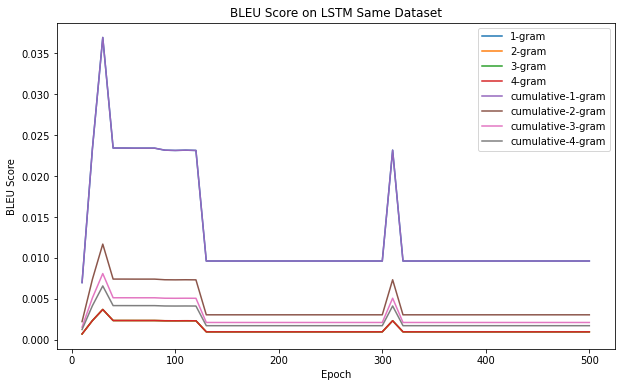

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(bleu_score['epoch'], bleu_score['1-gram'], label='1-gram')
plt.plot(bleu_score['epoch'], bleu_score['2-gram'], label='2-gram')
plt.plot(bleu_score['epoch'], bleu_score['3-gram'], label='3-gram')
plt.plot(bleu_score['epoch'], bleu_score['4-gram'], label='4-gram')
plt.plot(bleu_score['epoch'], bleu_score['cumulative-1-gram'], label='cumulative-1-gram')
plt.plot(bleu_score['epoch'], bleu_score['cumulative-2-gram'], label='cumulative-2-gram')
plt.plot(bleu_score['epoch'], bleu_score['cumulative-3-gram'], label='cumulative-3-gram')
plt.plot(bleu_score['epoch'], bleu_score['cumulative-4-gram'], label='cumulative-4-gram')
plt.xlabel('Epoch')
plt.ylabel('BLEU Score')
plt.title('BLEU Score on LSTM Same Dataset')
plt.legend()
# add number for each 100 epoch

In [ ]:
# import torch
# import torch.nn as nn
# from sklearn.model_selection import KFold

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# def train(source_data, target_data, model, epochs, batch_size, print_every, learning_rate):
#     model.to(device)
#     total_training_loss = 0
#     total_valid_loss = 0
#     loss = 0
    
#     optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#     criterion = nn.NLLLoss()

#     # use cross validation
#     kf = KFold(n_splits=epochs, shuffle=True)

#     # run = neptune_init("LSTM_FLUENT_Baseline_2")

#     for e, (train_index, test_index) in enumerate(kf.split(source_data), 1):
#     model.to(device)
#     model.train()
#     for i in range(0, len(train_index)):

#         src = source_data[i]
#         trg = target_data[i]

#         output = model(src, trg, src.size(0), trg.size(0))

#         current_loss = 0
#         for (s, t) in zip(output["decoder_output"], trg): 
#             current_loss += criterion(s, t)

#         loss += current_loss
#         total_training_loss += (current_loss.item() / trg.size(0)) # add the iteration loss

#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#         loss = 0


#     # validation set 
#     model.eval()
#     for i in range(0, len(test_index)):
#         src = source_data[i]
#         trg = target_data[i]

#         output = model(src, trg, src.size(0), trg.size(0))

#         current_loss = 0
#         for (s, t) in zip(output["decoder_output"], trg): 
#             current_loss += criterion(s, t)

#         total_valid_loss += (current_loss.item() / trg.size(0)) # add the iteration loss


#     if e % print_every == 0:
#         training_loss_average = total_training_loss / (len(train_index)*print_every)
#         validation_loss_average = total_valid_loss / (len(test_index)*print_every)
#         print("{}/{} Epoch  -  Training Loss = {:.4f}  -  Validation Loss = {:.4f}".format(e, epochs, training_loss_average, validation_loss_average))
#         # run['train/loss'].append(training_loss_average)
#         total_training_loss = 0
#         total_valid_loss = 0 



In [18]:
seq2seq = Seq2Seq(Q_vocab.words_count, hidden_size, A_vocab.words_count)

train(source_data = source_data,
    target_data = target_data,
    model = seq2seq,
    print_every = 1,
    epochs = epochs,
    learning_rate = learning_rate,
    batch_size = batch_size
)


[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/andialifs/siet-24/e/SIET-172
1/150 Epoch  -  Training Loss = 7.7315  -  Validation Loss = 7.1495
2/150 Epoch  -  Training Loss = 6.7575  -  Validation Loss = 6.5846


KeyboardInterrupt: 

In [21]:
model.state_dict()

OrderedDict([('encoder.embedding.weight',
              tensor([[ 1.2180,  2.3957,  0.0216,  ...,  0.1178, -1.6404,  1.4385],
                      [ 0.2498,  0.5579, -0.2960,  ..., -0.7027, -0.3493, -1.5135],
                      [ 1.9521,  0.6869,  0.4072,  ...,  0.7167, -2.0514,  1.1361],
                      ...,
                      [-1.2900, -1.6707, -1.3739,  ...,  0.2082,  0.3778, -2.0578],
                      [-0.5127, -0.9172, -1.3340,  ..., -0.6937,  0.9553,  1.1674],
                      [ 1.7684, -1.3130, -1.8440,  ..., -0.4877,  2.1086,  0.8863]],
                     device='cuda:0')),
             ('encoder.input.weight',
              tensor([[-0.0131,  0.0542,  0.0858,  ...,  0.0804, -0.0135,  0.0493],
                      [-0.0762,  0.0377, -0.0451,  ..., -0.0508,  0.0025,  0.0876],
                      [-0.0358,  0.0494,  0.0072,  ...,  0.0135,  0.0161,  0.0795],
                      ...,
                      [-0.0878, -0.0809,  0.0564,  ...,  0.0885,  0.0

In [35]:
# import torch

# model_path = 'seq2seq.pt'

# torch.save(seq2seq, model_path)

# seq2seq = torch.load(model_path, map_location=torch.device('cuda'))
# seq2seq.eval()

NameError: name 'seq2seq' is not defined

# Eval

In [25]:
question_eval = question_eval[:5]
answer_eval = answer_eval[:5]

preds = []

for question in question_eval:
    question_tensor = toTensor(Q_vocab, question)
    src_len = question_tensor.size(0)
    trg_len = 20

    output = model(question_tensor, question_tensor, src_len, trg_len)
    pred = [A_vocab.index2word[i.item()] for i in output['decoder_output'][0].argmax(1)]
    pred = ' '.join(pred)
    preds.append(pred)

results = calculate_bleu(preds, question_eval, answer_eval)

In [21]:
src = "visi filkom"
output = model(toTensor(Q_vocab, src), toTensor(A_vocab, " "), len(src.split()), 30)
response = ""
for o in output["decoder_output"]:
    response += A_vocab.index2word[o.argmax().item()] + " "

print("<", response)

< menjadi fakulta yang berdaya sa internasion dan berkontribusi kepada pengembangan teknolog informasi dan ilmu komput untuk menunjang industri dan masyarakat dengan menyelaraskan pelaksanaan pendidikan penelitian dan pengabdian kepada masyarakat menjadi 
